# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
import pyspark
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc,isnan, udf, isnull,sum
from pyspark.sql import Window
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Load dataset
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
# Clean dataset from missing userid's & missing sessionid's
print("Number of records before cleaning: " + str(user_log.count()))
print("Number of records after cleaning: " + str(user_log.dropna(how = "any", subset = ["userId", "sessionId"]).filter(user_log["userId"] != "").count()))

Number of records before cleaning: 286500
Number of records after cleaning: 278154


In [5]:
user_log = user_log.dropna(how = "any", subset = ["userId", "sessionId"]).filter(user_log["userId"] != "")

In [6]:
user_log.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Dataset overview
data_cols = [
    'artist',
    'auth',
    'firstName',
    'gender',
    'itemInSession',
    'lastName',
    'length',
    'level',
    'location',
    'method',
    'page',
    'registration',
    'sessionId',
    'song',
    'status',
    'ts',
    'userAgent',
    'userId'
]
for col in data_cols:
    user_log.describe(col).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+---------+
|summary|     auth|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min|Cancelled|
|    max|Logged In|
+-------+---------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|          

In [9]:
# Data sample
user_log.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [10]:
# What page contains
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



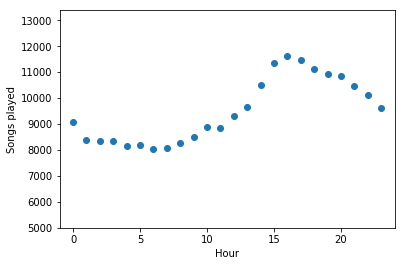

In [11]:
# See interactions per hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(5000, 1.15 * songs_in_hour_pd["count"].max())
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [12]:
user_log.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|  20|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/

In [13]:
user_log.filter("page = 'Cancellation Confirmation'").count()

52

In [14]:
flag_churn_event = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())

In [15]:
user_log = user_log.withColumn("churn", flag_churn_event("page"))

In [16]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', churn=0)

In [17]:
user_log.select(["userId", "firstname", "page", "level", "song", "churn"]).where(user_log.userId == "54").show(11100)

+------+---------+--------------------+-----+--------------------+-----+
|userId|firstname|                page|level|                song|churn|
+------+---------+--------------------+-----+--------------------+-----+
|    54|    Alexi|            NextSong| paid|         What I Mean|    0|
|    54|    Alexi|            NextSong| paid|You'll Never Know...|    0|
|    54|    Alexi|            NextSong| paid|             For You|    0|
|    54|    Alexi|            NextSong| paid|          Girl Money|    0|
|    54|    Alexi|           Downgrade| paid|                null|    0|
|    54|    Alexi|            NextSong| paid|          My Name Is|    0|
|    54|    Alexi|            NextSong| paid|The Kids Dont St...|    0|
|    54|    Alexi|           Thumbs Up| paid|                null|    0|
|    54|    Alexi|            NextSong| paid|   N A Whitemanzeyez|    0|
|    54|    Alexi|            NextSong| paid|Ghosts 'n' Stuff ...|    0|
|    54|    Alexi|            NextSong| paid|Till T

In [18]:
window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log = user_log.withColumn("churn", Fsum("churn").over(window))

In [19]:
user_log.select(["userId", "firstname", "ts", "page", "level", "churn"]).where(user_log.userId == "54").sort("ts").show(10000)

+------+---------+-------------+--------------------+-----+-----+
|userId|firstname|           ts|                page|level|churn|
+------+---------+-------------+--------------------+-----+-----+
|    54|    Alexi|1538353930000|            NextSong| paid|    1|
|    54|    Alexi|1538354180000|            NextSong| paid|    1|
|    54|    Alexi|1538354396000|            NextSong| paid|    1|
|    54|    Alexi|1538354739000|            NextSong| paid|    1|
|    54|    Alexi|1538354749000|           Downgrade| paid|    1|
|    54|    Alexi|1538354985000|            NextSong| paid|    1|
|    54|    Alexi|1538355254000|            NextSong| paid|    1|
|    54|    Alexi|1538355255000|           Thumbs Up| paid|    1|
|    54|    Alexi|1538395957000|            NextSong| paid|    1|
|    54|    Alexi|1538396264000|            NextSong| paid|    1|
|    54|    Alexi|1538396638000|            NextSong| paid|    1|
|    54|    Alexi|1538396906000|            NextSong| paid|    1|
|    54|  

In [20]:
user_log.filter("churn == 1").dropDuplicates(["userId"]).count()

52

In [21]:
user_log.filter("churn == 0").dropDuplicates(["userId"]).count()

173

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
# See how users who stayed & users who churned behaviours
user_log.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show(40)

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    1|               Error|    32|
|    0|               Error|   220|
|    1|                Help|   239|
|    0|                Help|  1215|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
|    1|         Roll Advert|   967|
|    0|         Roll Advert|  2966|
|    0|       Save Settings|   252|
|    1|       Save Settings|    58|
|    1|            Settings|

- Add Friend
- Add to playlist
- Home
- NextSong
- Submit Upgrade
- Thumbs Up
- Thumbs Down
> The less the interactions with the above items, the most likely that the user will confirm cancellation.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
# Features Extraction.
# Total Songs Listened To
feature_1 = user_log.select('userId', 'song').groupBy('userId').count()\
        .withColumnRenamed('count', 'total_songs')

# Total Listening Duration
feature_2 = user_log.select('userID','length').groupBy('userID').agg({'length':'sum'})\
        .withColumnRenamed('sum(length)', 'listening_duration')

# Total Thumbs Up
feature_3 = user_log.select('userID','page').where(user_log.page == 'Thumbs Up').groupBy('userID').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'total_thumbs_up')

# Total Thumbs Down
feature_4 = user_log.select('userID','page').where(user_log.page == 'Thumbs Down').groupBy('userID').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'total_thumbs_down')

# Total Adding Songs to Playlist
feature_5 = user_log.select('userID','page').where(user_log.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'})\
        .withColumnRenamed('count(page)', 'adding_to_playlist')

# Total Friends
feature_6 = user_log.select('userId', 'page').where(user_log.page == 'Add Friend').groupBy('userId').count()\
        .withColumnRenamed('count', 'total_friends')

# How Many Songs Per Session
feature_7  = user_log.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId').agg({'count' : 'avg'})\
        .withColumnRenamed('avg(count)', 'avg_played_songs')

# How Many Songs Per Artist
feature_8 = user_log.filter(user_log.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artist_played")

In [24]:
# Setting The Label For The Model & Combine It With The Features Exctracted Above.
label = user_log.select('userId', 'churn').dropDuplicates().withColumnRenamed('churn', 'label')
features_with_label = [
    feature_1,
    feature_2,
    feature_3,
    feature_4,
    feature_5,
    feature_6,
    feature_7,
    feature_8,
    label
]
combined_data = features_with_label[0]
for feature in features_with_label[1:]:
    combined_data = combined_data.join(feature, 'userID','outer')

In [25]:
combined_data = combined_data.drop('userId').fillna(0)

In [26]:
combined_data.show()

+-----------+------------------+---------------+-----------------+------------------+-------------+------------------+-------------------+-----+
|total_songs|listening_duration|total_thumbs_up|total_thumbs_down|adding_to_playlist|total_friends|  avg_played_songs|total_artist_played|label|
+-----------+------------------+---------------+-----------------+------------------+-------------+------------------+-------------------+-----+
|        381| 66940.89735000003|             17|                5|                 7|            4|39.285714285714285|                252|    0|
|        474| 94008.87593999993|             21|                6|                 8|            4|              64.5|                339|    0|
|         11|2089.1131000000005|              0|                0|                 0|            0|               8.0|                  8|    1|
|       4825|1012312.0927899999|            171|               41|               118|           74|145.67857142857142|            

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [27]:
input_cols = ['total_songs',
 'listening_duration',
 'total_thumbs_up',
 'total_thumbs_down',
 'adding_to_playlist',
 'total_friends',
 'avg_played_songs',
 'total_artist_played',
 ]
assembler = VectorAssembler(inputCols=input_cols, outputCol="NumFeatures")
combined_data = assembler.transform(combined_data)

In [28]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler2.fit(combined_data)
combined_data = scalerModel.transform(combined_data)

In [29]:
combined_data.show()

+-----------+------------------+---------------+-----------------+------------------+-------------+------------------+-------------------+-----+--------------------+--------------------+
|total_songs|listening_duration|total_thumbs_up|total_thumbs_down|adding_to_playlist|total_friends|  avg_played_songs|total_artist_played|label|         NumFeatures|            features|
+-----------+------------------+---------------+-----------------+------------------+-------------+------------------+-------------------+-----+--------------------+--------------------+
|        381| 66940.89735000003|             17|                5|                 7|            4|39.285714285714285|                252|    0|[381.0,66940.8973...|[0.28656706364427...|
|        474| 94008.87593999993|             21|                6|                 8|            4|              64.5|                339|    0|[474.0,94008.8759...|[0.35651650437634...|
|         11|2089.1131000000005|              0|                0

In [30]:
combined_data_modeling = combined_data.select('label','features')

In [31]:
combined_data_modeling.take(1)

[Row(label=0, features=DenseVector([0.2866, 0.2431, 0.2596, 0.3823, 0.214, 0.1943, 0.9219, 0.4173]))]

In [32]:
# Prepare models to train & Split data.
train,validation = combined_data_modeling.randomSplit([0.8, 0.2], seed=50)
logistic_reg = LogisticRegression(maxIter=10, regParam =0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10,  regParam = 0.01)

In [33]:
# Logistic regression model
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.6679860940516678, 0.6759999806123697, 0.6759999806123697]

In [34]:
# Support vector machine model
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q2 = crossval.fit(train)
cvModel_q2.avgMetrics

[0.6759999806123697, 0.6759999806123697, 0.6759999806123697]

In [35]:
# Gradient boosted tree model
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q3 = crossval.fit(train)


[0.6857262137973704, 0.682360622557116]

In [45]:
cvModel_q3.avgMetrics

[0.6857262137973704, 0.682360622557116]

In [36]:
gbt_tuned = GBTClassifier(maxDepth=5,maxIter=10,seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

In [37]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.7297297297297297
0.7174976700838771


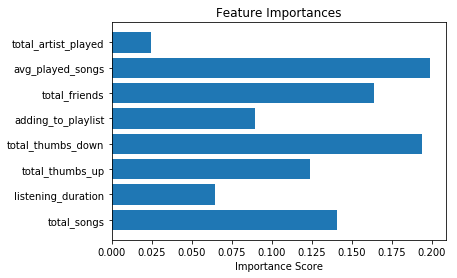

In [42]:
importances = gbt_model.featureImportances.values
feature = input_cols
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('Feature Importances');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.